In [1]:
from anomaly_detection import config, dataset, features
import numpy as np
import seaborn as sns

# set seed for reproducibility
np.random.seed(42)

In [2]:
file_path = '/Users/emadchelhi/Desktop/git_repos/Why-anomalous/data/raw/Wholesale customers data.csv'

# load the data
tab_df = dataset.load_data(file_path)

Data successfully loaded from /Users/emadchelhi/Desktop/git_repos/Why-anomalous/data/raw/Wholesale customers data.csv.


In [3]:
# excluding the categorical columns
del tab_df['Channel']
del tab_df['Region']

In [4]:
# log-transform the data
tab_df = features.logarithm(tab_df, 100)

### Outlier detection model

Knowing that the number of neighbors determines whether the model is robust or not (reproducible), we decided, under suggestion, to calculate, for each point, the distance to all other points and, instead, of using the minimum distance or an average one, we used the soft-minimum distance, that smoothly incorporates the effect of all distances weighting more closer neighbors.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.neighbors import NearestNeighbors


def soft_min(scores, gamma):
    softmin = (-1 / gamma) * (np.log((1 / (len(scores) - 1)) * np.sum(np.exp(-gamma * scores))))
    return softmin

def compute_anomaly_scores(train_data, test_data, gamma):
    # Fit nearest neighbors model on the training data
    nbrs = NearestNeighbors(n_neighbors=len(train_data), algorithm='ball_tree').fit(train_data)

    # Calculate distances to nearest neighbors on the test data
    distances, _ = nbrs.kneighbors(test_data)

    # Calculate softmin-based anomaly scores
    anomaly_scores = []
    for i in range(len(distances)):
        scores = distances[i][:-1]
        anomaly_score = soft_min(scores, gamma)
        anomaly_scores.append(anomaly_score)


    return np.array(anomaly_scores)

# Set gamma values
gamma_values = np.logspace(-4, 2, 7)

# Split data into training and test sets
train_data, test_data = train_test_split(tab_df, test_size=0.2, random_state=74)

# Iterate over each gamma value
for gamma in gamma_values:
    # Initialize arrays to store mean and deviation of each datapoint across bootstraps
    mean_scores = np.zeros(len(test_data))
    deviation_scores = np.zeros(len(test_data))

    # Bootstrap and evaluate
    for _ in range(100):  # Perform 100 bootstraps
        # Bootstrap the training data
        bootstrapped_train_data = resample(train_data, replace=True, n_samples=np.ceil(0.7 * len(train_data)).astype(int))
        # Compute anomaly scores on the test data using bootstrapped training data
        anomaly_scores = compute_anomaly_scores(bootstrapped_train_data, test_data, gamma)

        # Accumulate anomaly scores for each datapoint
        mean_scores += anomaly_scores
        deviation_scores += anomaly_scores ** 2

    # Calculate mean and deviation of each datapoint across bootstraps
    mean_scores /= 100
    deviation_scores /= 100
    deviation_scores -= mean_scores ** 2
    deviation_scores = np.sqrt(deviation_scores)

    # Normalize the mean and deviation scores
    mean_scores_norm = (mean_scores - np.mean(mean_scores)) / np.std(mean_scores)
    deviation_scores_norm = (deviation_scores - np.mean(deviation_scores)) / np.std(deviation_scores)

    # Calculate metric that benefits low deviation and high difference in mean between normal and anomalous data
    outliers = np.where(mean_scores_norm > np.percentile(mean_scores_norm, 97))[0]
    non_outliers = np.where(mean_scores_norm <= np.percentile(mean_scores_norm, 97))[0]
    metric = np.mean(np.abs(np.mean(outliers) - np.mean(non_outliers))) / np.mean((deviation_scores_norm)**2)
    print(np.mean(np.abs(np.mean(outliers) - np.mean(non_outliers))))
    print(np.mean((deviation_scores_norm)**2))
    print("Gamma: ", gamma, " Metric: ", metric)

    # Plotting
    sorted_indices = np.argsort(mean_scores)
    mean_scores = mean_scores[sorted_indices]
    deviation_scores = deviation_scores[sorted_indices]
    plt.figure(figsize=(10, 8))
    plt.errorbar(range(len(mean_scores)), mean_scores, yerr=deviation_scores, fmt='o', markersize=3)
    plt.xlabel('Data Point')
    plt.ylabel('Anomaly Score')
    plt.title(f'Anomaly Scores for Gamma={gamma:.5f}')
    plt.savefig(f'anomaly_scores_gamma_{gamma:.5f}.png')
    plt.close()

8.109803921568627
1.0000000000000002
Gamma:  0.0001  Metric:  8.109803921568625
8.109803921568627
1.0
Gamma:  0.001  Metric:  8.109803921568627
8.109803921568627
1.0
Gamma:  0.01  Metric:  8.109803921568627
8.109803921568627
1.0
Gamma:  0.1  Metric:  8.109803921568627
8.109803921568627
1.0
Gamma:  1.0  Metric:  8.109803921568627
7.41960784313725
1.0
Gamma:  10.0  Metric:  7.41960784313725
15.356862745098042
0.9999999999999999
Gamma:  100.0  Metric:  15.356862745098043


**Rq**: gamma is a positive constant that controls the sharpness of the approximation. Higher values of gamma make the approximation closer to the true minimum, while lower values make it more "soft" or smoothed.


In the formula of the soft-min distance, there is a hyper-parameter (gamma) that controls the approximation, that we had to tune. 


For each gamma we tried (gamma_values = np.logspace(-4, 2, 7)), we performed 100 bootstraps (with repetition) and computed mean and variance of each instance. Then through the formalization of a metric to evaluate and visual inspection, we chose gamma=0.01, that returned the biggest difference/ distance between anomalous and non anomalous records and smallest variance among the 100 samples. 


Let's analyze the custom evaluation metric. As said we're searching for the max separation between outliers and non-outliers so at the numerator we measured the difference between the anomalies mean and non-anomalies one. We the adjusted it with the mean quadratic normalized deviation. We searched for the highest metric's result.

In [6]:
gamma = 0.01
anomaly_scores = compute_anomaly_scores(tab_df, tab_df, gamma)

### Explainability

At this point, we reconsidered the 2 categorical features removed at the beginning and tried to inspect how anomalies spread among regions and retailers. We discovered that most anomalous spending behaviors come from other regions and from the hotel, restaurant and café business.

Data successfully loaded from /Users/emadchelhi/Desktop/git_repos/Why-anomalous/data/raw/Wholesale customers data.csv.


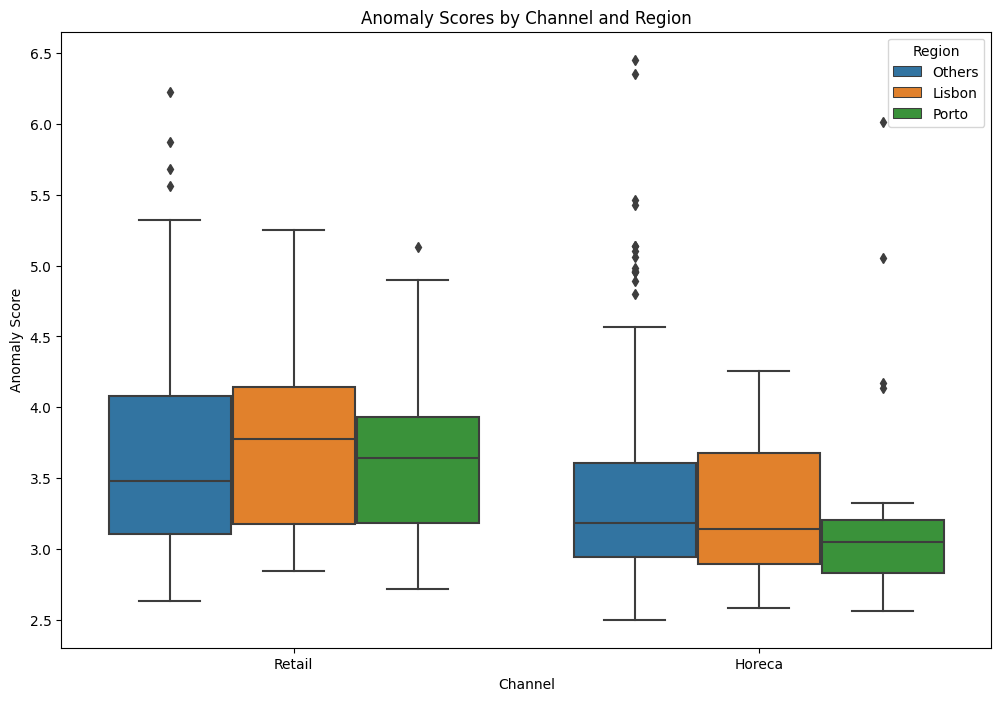

/var/folders/1x/nt297b5d1n771twhnkz_vs_80000gn/T/ipykernel_24885/4269836696.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers = meta_data.groupby(['Channel', 'Region']).apply(find_outliers).reset_index(drop=True)


In [7]:
# Use the channel and region data to see if there is a relation between the anomalies and the meta-data

# Load the meta-data
file_path = '/Users/emadchelhi/Desktop/git_repos/Why-anomalous/data/raw/Wholesale customers data.csv'
meta_data = dataset.load_data(file_path)

# Replace numerical values with string labels
channel_names = {1: 'Horeca', 2: 'Retail'}
region_names = {1: 'Lisbon', 2: 'Porto', 3: 'Others'}
meta_data['Channel'] = meta_data['Channel'].replace(channel_names)
meta_data['Region'] = meta_data['Region'].replace(region_names)

# Add the anomaly scores to the meta-data
meta_data['Anomaly Score'] = anomaly_scores
meta_data['Original Index'] = meta_data.index

# Plot the distribution of anomaly scores for each group in box plots
plt.figure(figsize=(12, 8))
sns.boxplot(x='Channel', y='Anomaly Score', hue='Region', data=meta_data)
plt.title('Anomaly Scores by Channel and Region')
plt.savefig('anomaly_scores_channel_region.png')
plt.show()
plt.close()

# Identify outliers using the IQR method for each group
def find_outliers(group):
    Q1 = group['Anomaly Score'].quantile(0.25)
    Q3 = group['Anomaly Score'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = group[(group['Anomaly Score'] < (Q1 - 1.5 * IQR)) | (group['Anomaly Score'] > (Q3 + 1.5 * IQR))]
    return outliers

# Apply the function to each group
outliers = meta_data.groupby(['Channel', 'Region']).apply(find_outliers).reset_index(drop=True)

# Sort the anomalies by Channel and Region
outliers_grouped = outliers.sort_values(by=['Channel', 'Region'])

# Save the anomalies to a CSV file
outliers_grouped.to_csv('anomalies_by_channel_region.csv', index=False)

We then tried to explain the otlierness values obtained.
We did this through the 'neuralization - propagation' framework (from: G. Montavon, J. R. Kauffmann, W. Samek, and K.-R. Müller. Explaining the Predictions of Unsupervised Learning Models, volume 13200 of Lecture Notes in Computer Science, pages 117–138. Springer, 2020.)


 It consists of rewriting the unsupervised model as an equivalent functional neural network and then apply LRP to provide explanations of the model predictions. 


In [8]:
import numpy as np
from anomaly_detection import features

# Compute anomaly contributions for the entire dataset
anomaly_contributions = features.compute_anomaly_contributions(tab_df.to_numpy(), gamma, anomaly_scores)

# Propagate anomaly contributions back to input features
feature_contributions = features.propagate_feature_contributions(anomaly_contributions, tab_df.to_numpy())

# Plot a scatter plot the data points with the anomaly score as the color use PCA to make it 2D and make it interactive so that you can hover over the points to see the feature contributions
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# Perform PCA on the data
pca = PCA(n_components=3)
pca.fit(tab_df)
pca_tab_df = pca.transform(tab_df)
pca_tab_df = pd.DataFrame(pca_tab_df, columns=['PC1', 'PC2', 'PC3'])

# Create a DataFrame with the PCA results and the anomaly scores
pca_tab_df['Anomaly Score'] = anomaly_scores
pca_tab_df['Anomaly Score'] = (pca_tab_df['Anomaly Score'] - pca_tab_df['Anomaly Score'].min()) / (pca_tab_df['Anomaly Score'].max() - pca_tab_df['Anomaly Score'].min())

# Add the original index to the DataFrame
pca_tab_df['Index'] = tab_df.index

# Feature names
feature_names = tab_df.columns[:]

# Add the feature contributions to the DataFrame
for i in range(tab_df.shape[1]):
    pca_tab_df[feature_names[i]] = feature_contributions[:, i]

# Plot the scatter plot
fig = px.scatter(pca_tab_df, x='PC1', y='PC2', color='Anomaly Score', hover_data=['Index'] + list(pca_tab_df.columns))
fig.update_traces(marker=dict(size=5))
fig.show()

# Save the plot as an HTML file
fig.write_html('plot_1.html')

Now plotted an interactive plot only for the outliers obtained through extreme-value analysis by channel and region.

In [9]:
# Perform PCA on the data
pca = PCA(n_components=3)
pca.fit(tab_df)
pca_tab_df = pca.transform(tab_df)
pca_tab_df = pd.DataFrame(pca_tab_df, columns=['PC1', 'PC2', 'PC3'])

# Create a DataFrame with the PCA results and the anomaly scores
pca_tab_df['Anomaly Score'] = anomaly_scores

# Add the original index to the DataFrame
pca_tab_df['Index'] = tab_df.index

# Feature names
feature_names = tab_df.columns[:]

# Add the feature contributions to the DataFrame
for i in range(tab_df.shape[1]):
    pca_tab_df[feature_names[i]] = feature_contributions[:, i]


pca_tab_df = pca_tab_df.iloc[outliers_grouped['Original Index'], :]

# Plot the scatter plot
fig = px.scatter(pca_tab_df, x='PC1', y='PC2', color='Anomaly Score', hover_data=['Index'] + list(pca_tab_df.columns))
fig.update_traces(marker=dict(size=5))
fig.show()

# Save the plot as an HTML file
fig.write_html('small_interactive_plot.html')